In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import mutual_info_regression as MIR

In [3]:
format_plots()
c = PlotConfig()

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
# prepare colors for plot
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
phasec = sns.color_palette("dana", n_colors=27)


# prepare colors for plot
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana2", cmap)
phasecf = sns.color_palette("dana2", n_colors=27)

/tmp/ipykernel_10331/813501115.py:6: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana", cmap)
/tmp/ipykernel_10331/813501115.py:15: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana2", cmap)


In [6]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [7]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()


## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]


# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [8]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))

m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

/tmp/ipykernel_10331/1663783390.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_data['sex'] = 'm'
/tmp/ipykernel_10331/1663783390.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['sex'] = 'f'


In [9]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)
data=pd.concat([m_data,f_data])

In [10]:
data.groupby(['age', 'sex']).size().reset_index(name='count')

,age,sex,count
0,4.0,f,15
1,4.0,m,14
2,8.0,f,16
3,8.0,m,16
4,12.0,f,16
5,12.0,m,15
6,20.0,f,15
7,20.0,m,16
8,24.0,f,16
9,24.0,m,16


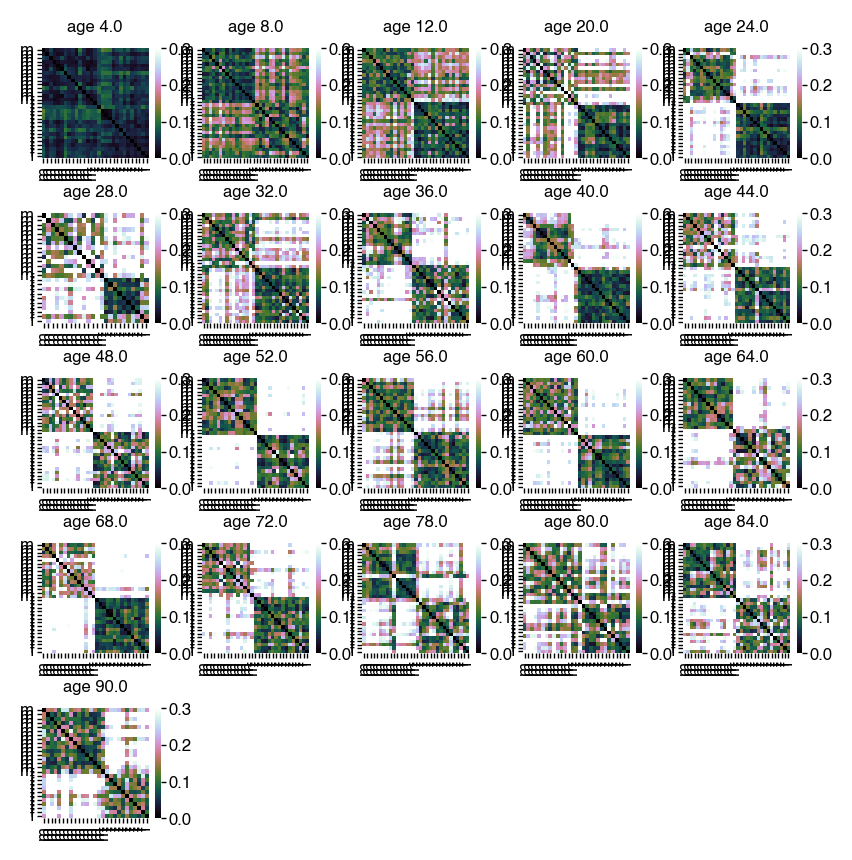

In [11]:
n=0
dist=[]
ages=[]
fig=plt.figure(figsize=(5, 5))
plt.subplots_adjust(hspace=0.5)
for age,_df in enumerate(data.groupby('age')):
    x = _df[1]
    sex = _df[1].index.get_level_values('sex').to_numpy()
    ax = plt.subplot(5, 5, n + 1)
    a=squareform(pdist(x, metric='cosine'))
    sns.heatmap(a,cmap ='cubehelix',
                vmax=0.3, 
                xticklabels= sex,
                yticklabels= sex
               )
    nm=sum(sex=='m')
    nf=sum(sex=='f')
    temp=a[0:nm,nm:]
    dist.extend(temp.mean(axis=1))
    ages.extend(_df[1][sex=='m'].index.get_level_values('age'))
    #sns.heatmap(x.T,cmap = 'cubehelix',vmax=0.1, xticklabels= sex)
    ax.set_title('age ' + str(_df[0]))
    n=n+1

In [12]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'fvm_dist_per_age_heatmaps_cosine.pdf', bbox_inches='tight')

In [13]:
df = pd.DataFrame()
df['dist'] = dist
df['age'] = ages

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


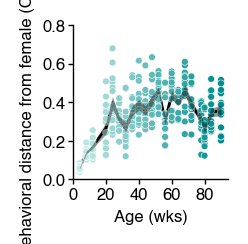

In [25]:
fig, ax = plt.subplots(figsize=(1, 1))
a = sns.scatterplot(
    data=df,
    x="age",
    y="dist",
    palette=cmm,
    hue="age",
    legend=False,
    s=6,
    linewidths=0,
    alpha=1,
    zorder=1,
)

a = sns.lineplot(
    data=df,
    x="age",
    y="dist",
    zorder=-1,
    color='black',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)

a.set(
    ylim=(0.0, 0.8),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Behavioral distance from female (Cosine)",
    xticks=[0,20,40,60,80],
)
sns.despine()

In [26]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'fvm_distance_of_males_from_females_over_life_cosine.pdf', bbox_inches='tight')

In [27]:
## statistics one-way anova

In [28]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tabulate import tabulate

In [29]:
def ow_anova(data, dependent_var, factor1):
    """
    Perform two-way ANOVA.
    
    Parameters:
    data (pd.DataFrame): The input data frame.
    dependent_var (str): The name of the dependent variable column.
    factor1 (str): The name of the first factor column.
    factor2 (str): The name of the second factor column.
    
    Returns:
    pd.DataFrame: The ANOVA results.
    """
    
    # Align the data
    align_data = data.copy()
    align_data['ranked_response'] = align_data[[dependent_var]]
    # Fit an OLS model on the ranked data
    model = ols(f'ranked_response ~ {factor1}', data=align_data).fit()
    # Perform ANOVA on the fitted model
    anova_results = sm.stats.anova_lm(model, typ=3)
    
    # Convert results to a DataFrame
    anova_df = pd.DataFrame(anova_results)
    
    return anova_df

In [30]:
anova_results = ow_anova(df,'dist', 'age')
print(tabulate(anova_results, headers='keys', tablefmt='psql'))

+-----------+----------+------+---------+---------------+
|           |   sum_sq |   df |       F |        PR(>F) |
|-----------+----------+------+---------+---------------|
| Intercept |  3.33218 |    1 | 234.922 |   5.27021e-40 |
| age       |  1.09747 |    1 |  77.373 |   9.45979e-17 |
| Residual  |  4.46802 |  315 | nan     | nan           |
+-----------+----------+------+---------+---------------+


In [21]:
from scikit_posthocs import posthoc_dunnett
control_age=4
posthoc_results = posthoc_dunnett(df, val_col='dist', group_col='age', control=control_age, alternative='greater')
posthoc_results

,4.0,8.0,12.0,20.0,24.0,28.0,32.0,36.0,40.0,44.0,...,52.0,56.0,60.0,64.0,68.0,72.0,78.0,80.0,84.0,90.0
4.0,1.0,0.071459,0.005071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.071459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12.0,0.005071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
print(tabulate(posthoc_results, headers='keys', tablefmt='psql'))

+----+-------------+-------------+--------------+---------------+--------+---------------+--------------+--------+--------+--------+--------+--------+---------------+--------+--------+--------+--------+---------------+---------------+--------+--------+
|    |         4.0 |         8.0 |         12.0 |          20.0 |   24.0 |          28.0 |         32.0 |   36.0 |   40.0 |   44.0 |   48.0 |   52.0 |          56.0 |   60.0 |   64.0 |   68.0 |   72.0 |          78.0 |          80.0 |   84.0 |   90.0 |
|----+-------------+-------------+--------------+---------------+--------+---------------+--------------+--------+--------+--------+--------+--------+---------------+--------+--------+--------+--------+---------------+---------------+--------+--------|
|  4 | 1           |   0.0714595 |   0.00507083 |   1.72159e-09 |      0 |   6.75127e-13 |   1.6362e-09 |      0 |      0 |      0 |      0 |      0 |   5.79869e-13 |      0 |      0 |      0 |      0 |   1.67866e-13 |   2.29411e-08 |      0